In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [2]:
class GridWorld:
    """Simple grid world environment for TD(λ) learning."""

    def __init__(self, size=5, goal_state=(4, 4), obstacle_states=None):
        self.size = size
        self.goal_state = goal_state
        self.obstacle_states = obstacle_states if obstacle_states else [(2, 2)]
        self.current_state = (0, 0)
        self.actions = ['up', 'down', 'left', 'right']

    def reset(self):
        """Reset environment to starting state."""
        self.current_state = (0, 0)
        return self.current_state

    def step(self, action):
        """Take action and return next state, reward, and done flag."""
        row, col = self.current_state

        # Determine next state based on action
        if action == 'up':
            next_state = (max(0, row - 1), col)
        elif action == 'down':
            next_state = (min(self.size - 1, row + 1), col)
        elif action == 'left':
            next_state = (row, max(0, col - 1))
        elif action == 'right':
            next_state = (row, min(self.size - 1, col + 1))
        else:
            next_state = self.current_state

        # Check if next state is an obstacle
        if next_state in self.obstacle_states:
            next_state = self.current_state
            reward = -1
        elif next_state == self.goal_state:
            reward = 10
        else:
            reward = -0.1

        self.current_state = next_state
        done = (next_state == self.goal_state)

        return next_state, reward, done

    def get_state_index(self, state):
        """Convert 2D state to 1D index."""
        return state[0] * self.size + state[1]

    def get_state_from_index(self, index):
        """Convert 1D index to 2D state."""
        return (index // self.size, index % self.size)

In [3]:
class TDLambda:
    """TD(λ) algorithm with eligibility traces."""

    def __init__(self, env, alpha=0.1, gamma=0.95, lambda_param=0.8):
       
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_param = lambda_param

        # Initialize value function
        self.num_states = env.size * env.size
        self.V = np.zeros(self.num_states)

        # Initialize eligibility traces
        self.eligibility_traces = np.zeros(self.num_states)

        # Track history for plotting
        self.episode_rewards = []
        self.episode_lengths = []
        self.value_history = []

    def select_action(self, epsilon=0.1):
        """Epsilon-greedy action selection."""
        if np.random.random() < epsilon:
            return np.random.choice(self.env.actions)
        else:
            # Simple policy: move towards goal
            row, col = self.env.current_state
            goal_row, goal_col = self.env.goal_state

            if row < goal_row:
                return 'down'
            elif row > goal_row:
                return 'up'
            elif col < goal_col:
                return 'right'
            else:
                return 'left'

    def train_episode(self, epsilon=0.1, accumulating=True):
        """
        Train for one episode using TD(λ).

        Args:
            epsilon: Exploration rate
            accumulating: If True, use accumulating traces; else replacing traces
        """
        state = self.env.reset()
        self.eligibility_traces = np.zeros(self.num_states)

        episode_reward = 0
        steps = 0

        while steps < 100:  # Max steps per episode
            # Select and take action
            action = self.select_action(epsilon)
            next_state, reward, done = self.env.step(action)

            episode_reward += reward
            steps += 1

            # Get state indices
            s_idx = self.env.get_state_index(state)
            s_next_idx = self.env.get_state_index(next_state)

            # TD error
            td_error = reward + self.gamma * self.V[s_next_idx] - self.V[s_idx]

            # Update eligibility trace for current state
            if accumulating:
                self.eligibility_traces[s_idx] += 1
            else:
                # Replacing traces
                self.eligibility_traces[s_idx] = 1

            # Update all values using eligibility traces
            self.V += self.alpha * td_error * self.eligibility_traces

            # Decay eligibility traces
            self.eligibility_traces *= self.gamma * self.lambda_param

            if done:
                break

            state = next_state

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(steps)
        self.value_history.append(self.V.copy())

    def train(self, num_episodes=500, epsilon=0.1):
        """Train for multiple episodes."""
        print(f"Training TD(λ) for {num_episodes} episodes...")
        print(f"Parameters: α={self.alpha}, γ={self.gamma}, λ={self.lambda_param}")

        for episode in range(num_episodes):
            self.train_episode(epsilon)

            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.episode_rewards[-100:])
                avg_length = np.mean(self.episode_lengths[-100:])
                print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, Avg Length = {avg_length:.1f}")

    def get_value_grid(self):
        """Convert value function to 2D grid."""
        grid = np.zeros((self.env.size, self.env.size))
        for i in range(self.num_states):
            state = self.env.get_state_from_index(i)
            grid[state[0], state[1]] = self.V[i]
        return grid

In [4]:
def visualize_results(agent, env):
    """Create comprehensive visualization of TD(λ) results."""
    fig = plt.figure(figsize=(16, 10))

    # 1. Value function heatmap
    ax1 = plt.subplot(2, 3, 1)
    value_grid = agent.get_value_grid()

    # Create custom colormap
    colors = ['red', 'yellow', 'green']
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

    sns.heatmap(value_grid, annot=True, fmt='.2f', cmap=cmap,
                cbar_kws={'label': 'State Value'}, ax=ax1)

    # Mark special states
    goal_row, goal_col = env.goal_state
    ax1.add_patch(plt.Rectangle((goal_col, goal_row), 1, 1,
                                 fill=False, edgecolor='blue', linewidth=3))

    for obs in env.obstacle_states:
        ax1.add_patch(plt.Rectangle((obs[1], obs[0]), 1, 1,
                                     fill=False, edgecolor='black', linewidth=3))

    ax1.set_title('Learned Value Function', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')

    # 2. Episode rewards
    ax2 = plt.subplot(2, 3, 2)
    window = 50
    smoothed_rewards = np.convolve(agent.episode_rewards,
                                   np.ones(window)/window, mode='valid')
    ax2.plot(agent.episode_rewards, alpha=0.3, label='Raw')
    ax2.plot(range(window-1, len(agent.episode_rewards)),
             smoothed_rewards, label=f'{window}-Episode Moving Avg', linewidth=2)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Total Reward')
    ax2.set_title('Learning Progress (Rewards)', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Episode lengths
    ax3 = plt.subplot(2, 3, 3)
    smoothed_lengths = np.convolve(agent.episode_lengths,
                                   np.ones(window)/window, mode='valid')
    ax3.plot(agent.episode_lengths, alpha=0.3, label='Raw')
    ax3.plot(range(window-1, len(agent.episode_lengths)),
             smoothed_lengths, label=f'{window}-Episode Moving Avg', linewidth=2)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Steps to Goal')
    ax3.set_title('Episode Lengths', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Value function evolution
    ax4 = plt.subplot(2, 3, 4)
    goal_idx = env.get_state_index(env.goal_state)
    start_idx = env.get_state_index((0, 0))

    episodes_to_plot = [0, len(agent.value_history)//4,
                        len(agent.value_history)//2, len(agent.value_history)-1]

    for ep_idx in episodes_to_plot:
        values = agent.value_history[ep_idx]
        ax4.plot(values, label=f'Episode {ep_idx}', alpha=0.7)

    ax4.axvline(x=start_idx, color='green', linestyle='--',
                alpha=0.5, label='Start State')
    ax4.axvline(x=goal_idx, color='red', linestyle='--',
                alpha=0.5, label='Goal State')
    ax4.set_xlabel('State Index')
    ax4.set_ylabel('Value')
    ax4.set_title('Value Function Evolution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Eligibility traces example
    ax5 = plt.subplot(2, 3, 5)

    # Run one episode and track eligibility traces
    state = env.reset()
    traces_history = []

    for _ in range(20):
        action = agent.select_action(epsilon=0)
        next_state, reward, done = env.step(action)

        s_idx = env.get_state_index(state)
        s_next_idx = env.get_state_index(next_state)

        td_error = reward + agent.gamma * agent.V[s_next_idx] - agent.V[s_idx]
        agent.eligibility_traces[s_idx] += 1
        agent.eligibility_traces *= agent.gamma * agent.lambda_param

        traces_history.append(agent.eligibility_traces.copy())

        if done:
            break
        state = next_state

    traces_array = np.array(traces_history).T
    im = ax5.imshow(traces_array, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax5.set_xlabel('Time Step')
    ax5.set_ylabel('State Index')
    ax5.set_title('Eligibility Traces Over Time', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax5, label='Trace Value')

    # 6. Final policy visualization
    ax6 = plt.subplot(2, 3, 6)
    policy_grid = np.zeros((env.size, env.size))

    # Create arrow map
    for i in range(env.size):
        for j in range(env.size):
            if (i, j) == env.goal_state:
                ax6.text(j, i, '★', ha='center', va='center',
                        fontsize=20, color='gold')
            elif (i, j) in env.obstacle_states:
                ax6.add_patch(plt.Rectangle((j-0.4, i-0.4), 0.8, 0.8,
                                           fill=True, color='black'))
            else:
                # Determine best action based on value function
                env.current_state = (i, j)
                best_value = float('-inf')
                best_action = None

                for action in env.actions:
                    temp_state = env.current_state
                    next_state, _, _ = env.step(action)
                    next_idx = env.get_state_index(next_state)

                    if agent.V[next_idx] > best_value:
                        best_value = agent.V[next_idx]
                        best_action = action

                    env.current_state = temp_state

                # Draw arrow
                arrow_map = {
                    'up': (0, -0.3),
                    'down': (0, 0.3),
                    'left': (-0.3, 0),
                    'right': (0.3, 0)
                }

                if best_action in arrow_map:
                    dx, dy = arrow_map[best_action]
                    ax6.arrow(j, i, dx, dy, head_width=0.2,
                             head_length=0.15, fc='blue', ec='blue')

    ax6.set_xlim(-0.5, env.size - 0.5)
    ax6.set_ylim(-0.5, env.size - 0.5)
    ax6.set_aspect('equal')
    ax6.invert_yaxis()
    ax6.set_xticks(range(env.size))
    ax6.set_yticks(range(env.size))
    ax6.grid(True)
    ax6.set_title('Learned Policy', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Column')
    ax6.set_ylabel('Row')

    plt.tight_layout()
    plt.show()

In [5]:
def compare_lambda_values():
    """Compare different λ values."""
    lambda_values = [0.0, 0.4, 0.8, 0.95]
    results = {}

    print("\n" + "="*60)
    print("Comparing different λ values")
    print("="*60)

    for lam in lambda_values:
        print(f"\nTraining with λ = {lam}")
        env = GridWorld(size=5, goal_state=(4, 4), obstacle_states=[(2, 2)])
        agent = TDLambda(env, alpha=0.1, gamma=0.95, lambda_param=lam)
        agent.train(num_episodes=300, epsilon=0.1)
        results[lam] = agent

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for lam, agent in results.items():
        window = 30
        smoothed = np.convolve(agent.episode_rewards,
                              np.ones(window)/window, mode='valid')
        axes[0].plot(range(window-1, len(agent.episode_rewards)),
                    smoothed, label=f'λ = {lam}', linewidth=2)

    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Smoothed Reward')
    axes[0].set_title('Learning Speed Comparison', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    for lam, agent in results.items():
        window = 30
        smoothed = np.convolve(agent.episode_lengths,
                              np.ones(window)/window, mode='valid')
        axes[1].plot(range(window-1, len(agent.episode_lengths)),
                    smoothed, label=f'λ = {lam}', linewidth=2)

    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Steps to Goal')
    axes[1].set_title('Episode Lengths Comparison', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Training TD(λ) for 500 episodes...
Parameters: α=0.1, γ=0.95, λ=0.8
Episode 100: Avg Reward = 7.67, Avg Length = 10.3
Episode 200: Avg Reward = 5.81, Avg Length = 12.3
Episode 300: Avg Reward = 5.53, Avg Length = 12.5
Episode 400: Avg Reward = 4.60, Avg Length = 13.7
Episode 500: Avg Reward = 5.14, Avg Length = 13.0


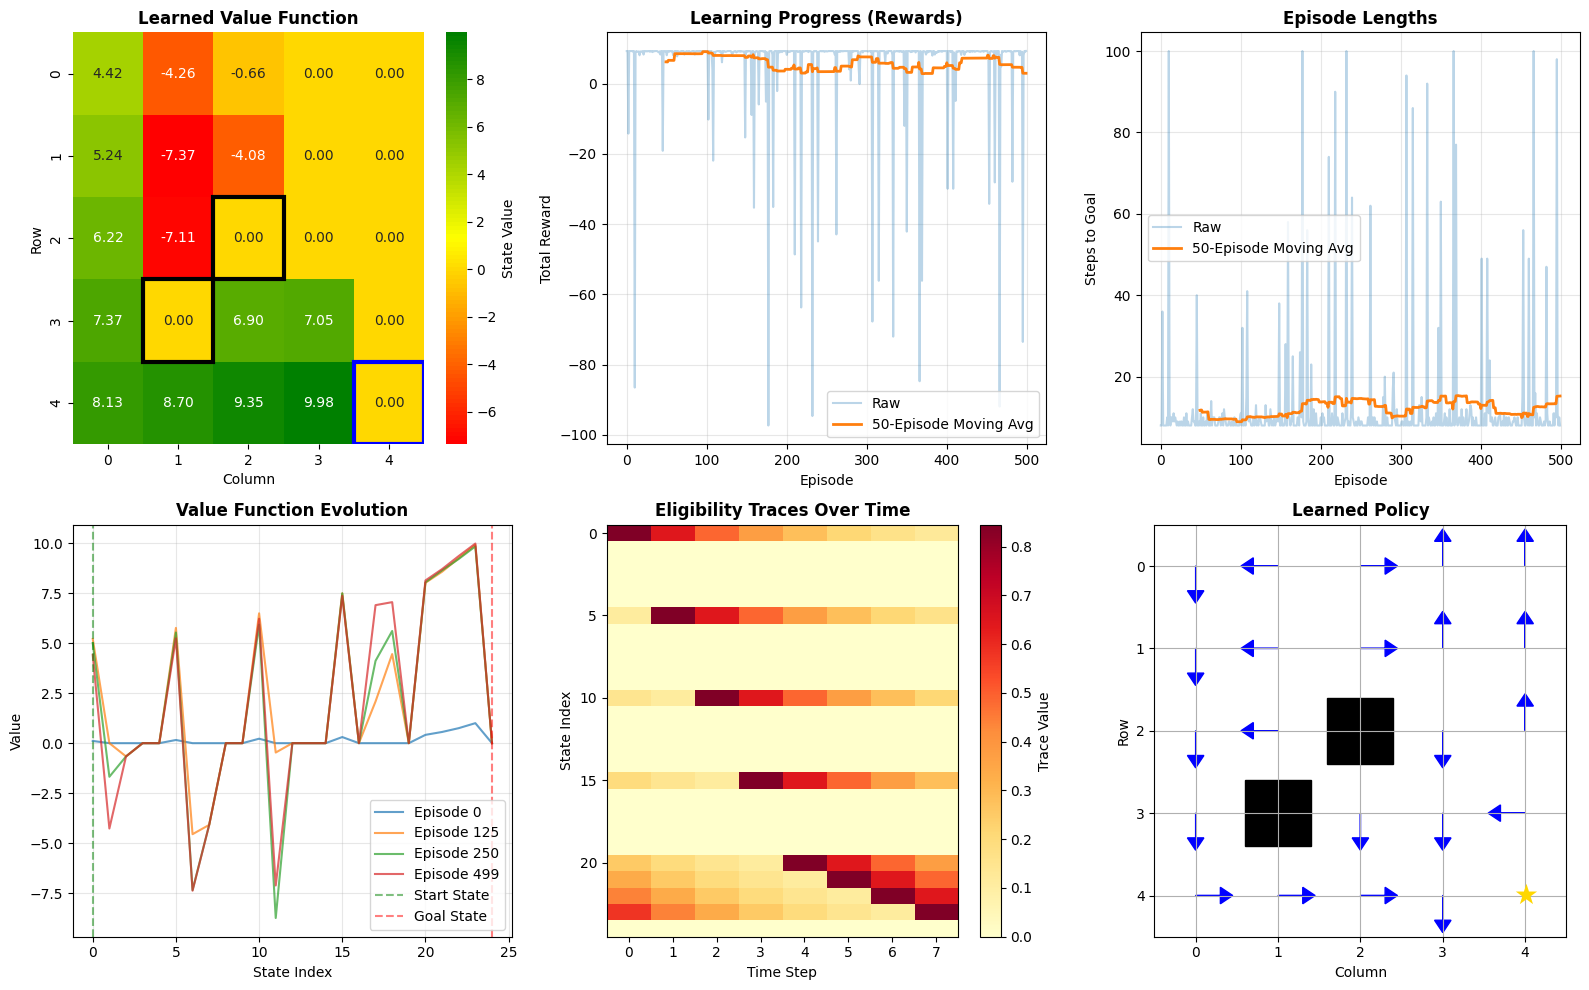

In [6]:
# Create environment
env = GridWorld(size=5, goal_state=(4, 4), obstacle_states=[(2, 2), (3, 1)])

# Create and train TD(λ) agent
agent = TDLambda(env, alpha=0.1, gamma=0.95, lambda_param=0.8)
agent.train(num_episodes=500, epsilon=0.1)

# Visualize results
visualize_results(agent, env)


Comparing different λ values

Training with λ = 0.0
Training TD(λ) for 300 episodes...
Parameters: α=0.1, γ=0.95, λ=0.0
Episode 100: Avg Reward = 9.22, Avg Length = 8.8
Episode 200: Avg Reward = 9.18, Avg Length = 9.1
Episode 300: Avg Reward = 9.22, Avg Length = 8.8

Training with λ = 0.4
Training TD(λ) for 300 episodes...
Parameters: α=0.1, γ=0.95, λ=0.4
Episode 100: Avg Reward = 9.22, Avg Length = 8.8
Episode 200: Avg Reward = 8.73, Avg Length = 9.4
Episode 300: Avg Reward = 9.21, Avg Length = 8.8

Training with λ = 0.8
Training TD(λ) for 300 episodes...
Parameters: α=0.1, γ=0.95, λ=0.8
Episode 100: Avg Reward = 9.23, Avg Length = 8.7
Episode 200: Avg Reward = 8.97, Avg Length = 9.1
Episode 300: Avg Reward = 9.21, Avg Length = 8.9

Training with λ = 0.95
Training TD(λ) for 300 episodes...
Parameters: α=0.1, γ=0.95, λ=0.95
Episode 100: Avg Reward = 9.20, Avg Length = 9.0
Episode 200: Avg Reward = 9.21, Avg Length = 8.9
Episode 300: Avg Reward = 9.13, Avg Length = 9.0


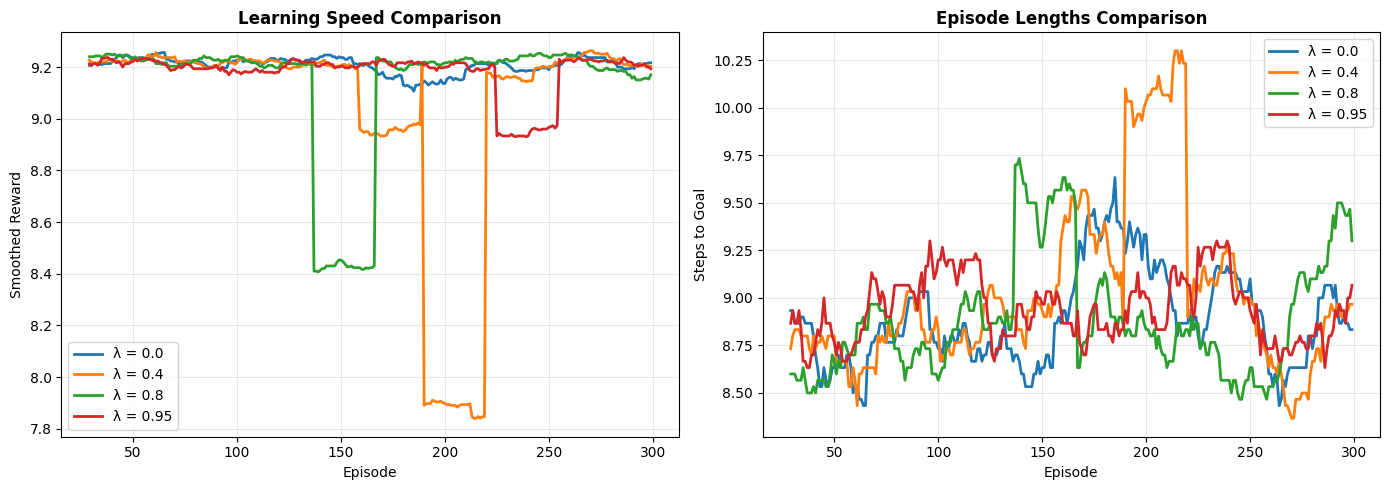

In [7]:
# Compare different lambda values
compare_lambda_values()